In [40]:
from pulp import *
import csv
import numpy as np
import pandas as pd
import os
import time
import collections
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from IPython.html.widgets import interact

%matplotlib inline
os.chdir('/home/valesco/Datasets/NFL_projs/')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

/home/valesco/anaconda3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [45]:
in_file = "2017_week_9_sim_set.csv"
reader = csv.DictReader(open(in_file, 'r'))
player_dict = []
for i , row in enumerate(reader):
    team = {k: v for k, v in row.items()}
    team['id'] = i
    player_dict.append(team)
    
players = [player['id'] for player in player_dict_pre]
teams = [0]
point_dict = []

for i in tqdm(range(10000)):    
    ## Find Optimal team
    
    opt = LpProblem('Optimizer', LpMaximize)
    possible_assignments = LpVariable.dicts("possible", (teams, players), 0, 1, LpBinary)

    #objective
    opt += sum([float(player['proj_points']) * possible_assignments[team][player['id']] for player in player_dict for team in teams])

    #set constraints
    for team in teams:
        opt += lpSum([possible_assignments[team][player['id']] for player in player_dict]) == 9, '6 players per team '+str(team)
        opt += lpSum([float(player['salary']) * possible_assignments[team][player['id']] for player in player_dict]) <= 50000
        opt += lpSum([float(player['salary']) * possible_assignments[team][player['id']] for player in player_dict]) >= 47000
        opt += lpSum([possible_assignments[team][player['id']] for player in player_dict if player['position'] == 'QB']) == 1, 'one QB per team '
        opt += lpSum([possible_assignments[team][player['id']] for player in player_dict if player['position'] == 'WR']) >= 3, 'two or more WR per team '
        opt += lpSum([possible_assignments[team][player['id']] for player in player_dict if player['position'] == 'RB']) >= 2, 'two or more RB per team '
        opt += lpSum([possible_assignments[team][player['id']] for player in player_dict if player['position'] == 'TE']) >= 1, 'two or more TE per team '
        opt += lpSum([possible_assignments[team][player['id']] for player in player_dict if player['position'] == 'D']) == 1, 'two or more DEF per team '
        #opt += lpSum([possible_assignments[team][player['id']] for player in player_dict if player['time_line'] == time]) == 9, 'same week'

    opt.writeLP('fantasy_optimization.lp')
    opt.solve()
    status = LpStatus[opt.status]
    selected = []
    max_sum = 0
    max_player_dict = []
    max_pid_ls = []

    for player in player_dict:
        if possible_assignments[0][player['id']].value() == 1.0:
            max_player_dict.append({'name':player['name'], 'proj_points': player['proj_points']})
            max_sum += float(player['proj_points'])
            max_pid_ls.append(player['id'])

    
    ##Find least optimal team
    
    opt = LpProblem('Optimizer', LpMinimize)
    possible_assignments = LpVariable.dicts("possible", (teams, players), 0, 1, LpBinary)

    #objective
    opt += sum([float(player['proj_points']) * possible_assignments[team][player['id']] for player in player_dict for team in teams])

    #set constraints
    for team in teams:
        opt += lpSum([possible_assignments[team][player['id']] for player in player_dict]) == 9, '6 players per team '+str(team)
        opt += lpSum([float(player['salary']) * possible_assignments[team][player['id']] for player in player_dict]) <= 50000
        opt += lpSum([float(player['salary']) * possible_assignments[team][player['id']] for player in player_dict]) >= 47000
        opt += lpSum([possible_assignments[team][player['id']] for player in player_dict if player['position'] == 'QB']) == 1, 'one QB per team '
        opt += lpSum([possible_assignments[team][player['id']] for player in player_dict if player['position'] == 'WR']) >= 3, 'two or more WR per team '
        opt += lpSum([possible_assignments[team][player['id']] for player in player_dict if player['position'] == 'RB']) >= 2, 'two or more RB per team '
        opt += lpSum([possible_assignments[team][player['id']] for player in player_dict if player['position'] == 'TE']) >= 1, 'two or more TE per team '
        opt += lpSum([possible_assignments[team][player['id']] for player in player_dict if player['position'] == 'D']) == 1, 'two or more DEF per team '
        #opt += lpSum([possible_assignments[team][player['id']] for player in player_dict if player['time_line'] == time]) == 9, 'same week'

    opt.writeLP('fantasy_optimization.lp')
    opt.solve()
    status = LpStatus[opt.status]
    selected = []
    min_sum = 0
    min_player_dict = []
    min_pid_ls = []

    for player in player_dict:
        if possible_assignments[0][player['id']].value() == 1.0:
            min_player_dict.append({'name':player['name'], 'proj_points': player['proj_points']})
            min_sum += float(player['proj_points'])
            min_pid_ls.append(player['id'])

    #calc difference between scores
    if i == 0:
        first_diff = max_sum - min_sum
        diff = first_diff
    else:
        diff = max_sum - min_sum
    
    for pid in player_dict:
        if pid['id'] in max_pid_ls:
            temp_points = float(pid['proj_points']) - (1 * (diff / first_diff))
            pid['proj_points'] = temp_points
            
            
        if pid['id'] in min_pid_ls:
            temp_points = float(pid['proj_points']) + (1 * (diff / first_diff))
            pid['proj_points'] = temp_points
            
    point_dict.append({'max_sum': max_sum, 'min_sum': min_sum})

100%|██████████| 10000/10000 [32:14<00:00,  7.52it/s]


In [48]:
point_dict[-30:]

[{'max_sum': 96.4567832956964, 'min_sum': 96.44064527054113},
 {'max_sum': 96.4567680518842, 'min_sum': 96.4406157088722},
 {'max_sum': 96.45673125955837, 'min_sum': 96.44062488046771},
 {'max_sum': 96.45670799949202, 'min_sum': 96.4406363306203},
 {'max_sum': 96.45671273153592, 'min_sum': 96.44060045205187},
 {'max_sum': 96.45670779280971, 'min_sum': 96.44064325163376},
 {'max_sum': 96.45667021771884, 'min_sum': 96.44061643353358},
 {'max_sum': 96.45662653341302, 'min_sum': 96.44059272261424},
 {'max_sum': 96.45663605905642, 'min_sum': 96.44055114920737},
 {'max_sum': 96.45654645916409, 'min_sum': 96.4405849010537},
 {'max_sum': 96.45658765411883, 'min_sum': 96.44050125520359},
 {'max_sum': 96.45653592075628, 'min_sum': 96.4405419663375},
 {'max_sum': 96.45653135302146, 'min_sum': 96.44050451831409},
 {'max_sum': 96.45649765039508, 'min_sum': 96.44047355771889},
 {'max_sum': 96.45641201103406, 'min_sum': 96.44052320971396},
 {'max_sum': 96.45648667164414, 'min_sum': 96.44039893318862}

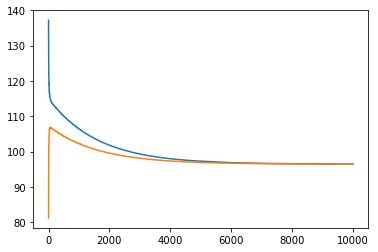

In [46]:
max_ls = []
min_ls = []
for iteration in point_dict:
    max_ls.append(iteration['max_sum'])
    min_ls.append(iteration['min_sum'])
    
plt.plot(max_ls)
plt.plot(min_ls)
plt.show()

In [49]:
max_player_dict

[{'name': 'Cam Newton', 'proj_points': 17.540696220700482},
 {'name': 'Michael Thomas', 'proj_points': 10.176510894085839},
 {'name': 'Mike Evans', 'proj_points': 10.17872661742742},
 {'name': 'Tyreek Hill', 'proj_points': 10.17427796429779},
 {'name': 'Chris Thompson', 'proj_points': 10.171607780024775},
 {'name': 'Aaron Jones', 'proj_points': 10.171199594325799},
 {'name': 'Houston Defense', 'proj_points': 7.725560553315987},
 {'name': 'Brandon LaFell', 'proj_points': 10.159658468091337},
 {'name': 'Ryan Griffin', 'proj_points': 10.157891591221526}]

In [50]:
min_player_dict

[{'name': 'Leonard Fournette', 'proj_points': 10.181516277354751},
 {'name': 'Julio Jones', 'proj_points': 10.178863980917521},
 {'name': 'Zach Ertz', 'proj_points': 10.174437915484804},
 {'name': 'Drew Stanton', 'proj_points': 17.533337258698804},
 {'name': 'DeVante Parker', 'proj_points': 10.171344089847691},
 {'name': 'Marshawn Lynch', 'proj_points': 10.162048696717646},
 {'name': 'Terrance Williams', 'proj_points': 10.158935003113218},
 {'name': 'Adam Humphries', 'proj_points': 10.158950651179271},
 {'name': 'Atlanta Defense', 'proj_points': 7.720851587574835}]

In [56]:
gto_df = pd.DataFrame.from_dict(player_dict)

qb_df = gto_df[gto_df['position'] == 'WR']

qb_df.sort_values('salary', ascending = False)

,id,name,player_id,position,proj_points,salary
25,25,DeAndre Hopkins,3873,WR,10.185300,9200
20,20,Julio Jones,4286,WR,10.179147,7800
21,21,Mike Evans,2823,WR,10.178444,7700
26,26,A.J. Green,3348,WR,10.177284,7400
17,17,Michael Thomas,19141,WR,10.176228,7200
72,72,Will Fuller,16902,WR,10.175473,7000
24,24,Doug Baldwin,1214,WR,10.175141,6900
29,29,Tyreek Hill,25839,WR,10.173995,6700
55,55,Amari Cooper,8590,WR,10.173721,6600
41,41,Michael Crabtree,2322,WR,10.173360,6500
